# Regularization and Evaluation of Neural Networks

In [1]:
from sklearn.datasets import load_sample_images
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2

## Learning Objectives

- use `keras` to code up a neural network model;
- explain dropout and early stopping as distinctive forms of regularization in neural networks;
- use wrappers inside `keras` to make models that can jibe with `sklearn`.

### From last time

In [2]:
digits = load_digits()
X = digits.data
y = digits.target

y_binary = y % 2

In [4]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X, y_binary, epochs=30, batch_size=10)

Epoch 1/30
  1/180 [..............................] - ETA: 1:03 - loss: 6.0923 - accuracy: 0.5000

2022-12-01 12:08:59.441850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


180/180 [==============================] - 2s 8ms/step - loss: 0.7878 - accuracy: 0.6845
Epoch 2/30
180/180 [==============================] - 1s 8ms/step - loss: 0.3470 - accuracy: 0.8436
Epoch 3/30
180/180 [==============================] - 1s 7ms/step - loss: 0.2515 - accuracy: 0.9009
Epoch 4/30
180/180 [==============================] - 1s 7ms/step - loss: 0.2012 - accuracy: 0.9176
Epoch 5/30
180/180 [==============================] - 1s 7ms/step - loss: 0.1622 - accuracy: 0.9410
Epoch 6/30
180/180 [==============================] - 1s 7ms/step - loss: 0.1335 - accuracy: 0.9494
Epoch 7/30
180/180 [==============================] - 1s 7ms/step - loss: 0.1133 - accuracy: 0.9555
Epoch 8/30
180/180 [==============================] - 1s 7ms/step - loss: 0.0976 - accuracy: 0.9661
Epoch 9/30
180/180 [==============================] - 1s 7ms/step - loss: 0.0845 - accuracy: 0.9688
Epoch 10/30
180/180 [==============================] - 1s 7ms/step - loss: 0.0765 - accuracy: 0.9711
Epoch 11/3

### Things to know:

- The data and labels in `fit()` need to be numpy arrays, not `pandas` dfs.
- Scaling your data will have a large impact on your model.
   > For our traditional input features, we would use a scaler object. For images, as long as the minimum value is 0, we can simply divide through by the maximum pixel intensity.

#### Getting data ready for modeling
**Preprocessing**:

- use train_test_split to create X_train, y_train, X_test, and y_test
- Split training data into pure_train and validation sets.
- Scale the pixel intensity to a value between 0 and 1.

Scaling our input variables will help speed up our neural network.

Since our minimum intensity is 0, we can normalize the inputs by dividing each value by the max value (16).

In [5]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y_binary, random_state=42, test_size=0.2)

X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train, random_state=42, test_size=0.2)

X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For activation, let's start with the familiar sigmoid function, and see how it performs.

In [6]:
model = Sequential()
# We will start with our trusty sigmoid function.
# What does input dimension correspond to?
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD' ,
              # We use binary_crossentropy for a binary loss function
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output. To see
# only the metrics at the end of each epoch, set verbose=2.
results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=100, verbose=1)

Epoch 1/10


2022-12-01 12:13:18.085426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 13ms/step - loss: 0.7337 - accuracy: 0.4961
Epoch 2/10
12/12 [==============================] - 0s 7ms/step - loss: 0.7251 - accuracy: 0.4961
Epoch 3/10
12/12 [==============================] - 0s 6ms/step - loss: 0.7186 - accuracy: 0.4961
Epoch 4/10
12/12 [==============================] - 0s 6ms/step - loss: 0.7136 - accuracy: 0.4961
Epoch 5/10
12/12 [==============================] - 0s 6ms/step - loss: 0.7095 - accuracy: 0.4961
Epoch 6/10
12/12 [==============================] - 0s 6ms/step - loss: 0.7064 - accuracy: 0.4961
Epoch 7/10
12/12 [==============================] - 0s 6ms/step - loss: 0.7039 - accuracy: 0.4961
Epoch 8/10
12/12 [==============================] - 0s 6ms/step - loss: 0.7018 - accuracy: 0.4961
Epoch 9/10
12/12 [==============================] - 0s 7ms/step - loss: 0.7003 - accuracy: 0.4961
Epoch 10/10
12/12 [==============================] - 0s 7ms/step - loss: 0.6990 - accuracy: 0.4961


We can access the history of our model via `results.history`.
Use __dict__ to take a tour.

In [7]:
results.__dict__

{'validation_data': None,
 'model': <keras.engine.sequential.Sequential at 0x11ace9610>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.7337154746055603,
   0.7250717282295227,
   0.7186118960380554,
   0.713564395904541,
   0.7095171213150024,
   0.7064443826675415,
   0.7038851976394653,
   0.7018161416053772,
   0.7002847790718079,
   0.6989840865135193],
  'accuracy': [0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434]},
 'params': {'verbose': 1, 'epochs': 10, 'steps': 12},
 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

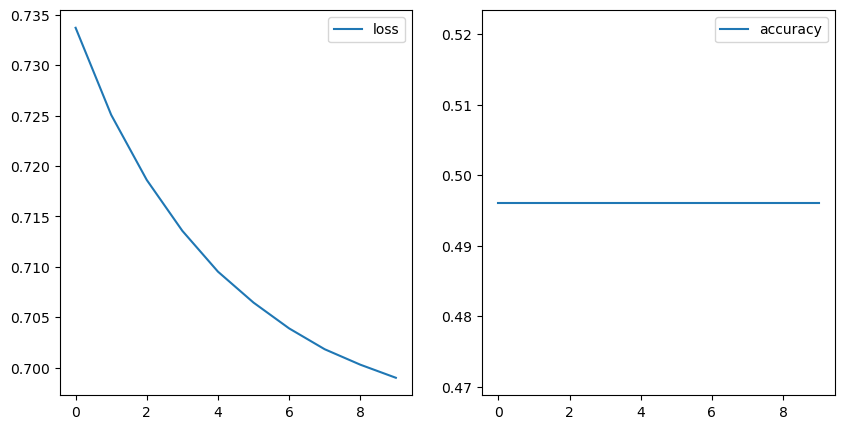

In [8]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

We have two plots above both relating to the quality of our model.  The left-hand plot is our loss. It uses the probabilities associated with our predictions to judge how well our prediction fits reality. We want it to decrease as far as possible.

The accuracy judges how well the predictions are after applying the threshold at the output layer.  We want accuracy to increase.

If we look at our loss, it is still decreasing. That is a signal that our model is **still learning**. If our model is still learning, we can allow it to get better by turning a few dials.

Let's:
- increase the number of epochs;
- change sigmoid activation in the hidden layers to ReLU; and
- decrease the batch size.

In [9]:
X_pure_train.shape[0]

1149

In [13]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
results = model.fit(X_pure_train, y_pure_train, epochs=50, batch_size=50, verbose=1)

Epoch 1/50
 7/23 [========>.....................] - ETA: 0s - loss: 0.7623 - accuracy: 0.4629

2022-12-01 12:17:49.625910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 0s 10ms/step - loss: 0.7180 - accuracy: 0.4848
Epoch 2/50
23/23 [==============================] - 0s 6ms/step - loss: 0.6695 - accuracy: 0.5492
Epoch 3/50
23/23 [==============================] - 0s 7ms/step - loss: 0.6494 - accuracy: 0.6484
Epoch 4/50
23/23 [==============================] - 0s 6ms/step - loss: 0.6338 - accuracy: 0.6963
Epoch 5/50
23/23 [==============================] - 0s 6ms/step - loss: 0.6190 - accuracy: 0.7137
Epoch 6/50
23/23 [==============================] - 0s 7ms/step - loss: 0.6042 - accuracy: 0.7250
Epoch 7/50
23/23 [==============================] - 0s 6ms/step - loss: 0.5889 - accuracy: 0.7346
Epoch 8/50
23/23 [==============================] - 0s 6ms/step - loss: 0.5729 - accuracy: 0.7502
Epoch 9/50
23/23 [==============================] - 0s 6ms/step - loss: 0.5568 - accuracy: 0.7650
Epoch 10/50
23/23 [==============================] - 0s 6ms/step - loss: 0.5403 - accuracy: 0.7720
Epoch 11/50
23/23 [==========

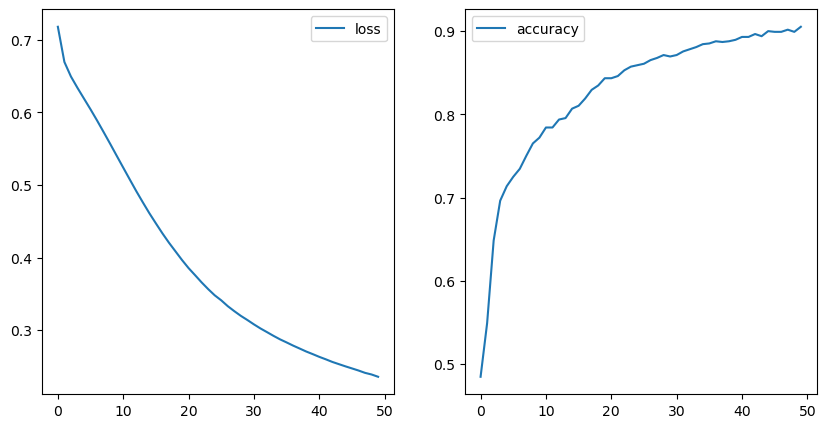

In [14]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

If we increase the learning rate to a very high number, we see that our model overshoots the minimum, and starts bouncing all around.

Epoch 1/30
  6/115 [>.............................] - ETA: 1s - loss: 29186.0723 - accuracy: 0.5167

2022-12-01 12:20:57.591645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


115/115 [==============================] - 1s 8ms/step - loss: 1525.0647 - accuracy: 0.4900
Epoch 2/30
115/115 [==============================] - 1s 6ms/step - loss: 1.1044 - accuracy: 0.4848
Epoch 3/30
115/115 [==============================] - 1s 7ms/step - loss: 0.9878 - accuracy: 0.5057
Epoch 4/30
115/115 [==============================] - 1s 7ms/step - loss: 0.9683 - accuracy: 0.5152
Epoch 5/30
115/115 [==============================] - 1s 6ms/step - loss: 1.0677 - accuracy: 0.4787
Epoch 6/30
115/115 [==============================] - 1s 6ms/step - loss: 0.9987 - accuracy: 0.4987
Epoch 7/30
115/115 [==============================] - 1s 6ms/step - loss: 0.9782 - accuracy: 0.4909
Epoch 8/30
115/115 [==============================] - 1s 6ms/step - loss: 1.0260 - accuracy: 0.4822
Epoch 9/30
115/115 [==============================] - 1s 6ms/step - loss: 1.0675 - accuracy: 0.4874
Epoch 10/30
115/115 [==============================] - 1s 7ms/step - loss: 0.8947 - accuracy: 0.5144
Epoch 1

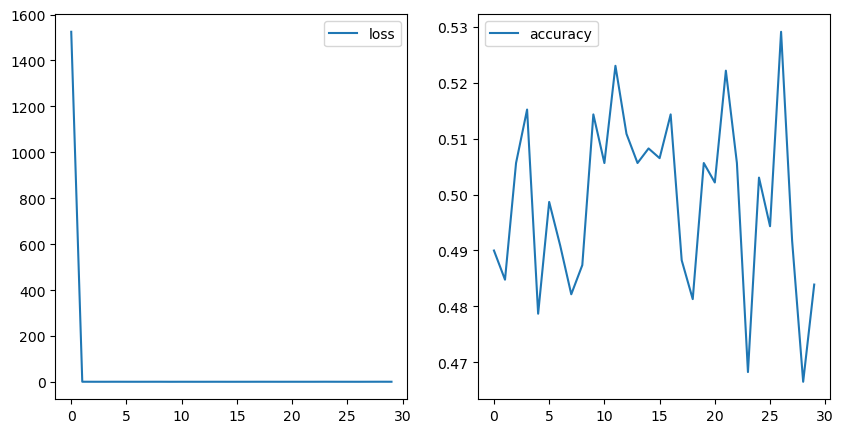

In [15]:
model = Sequential()

sgd = SGD(learning_rate=9)
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                    epochs=30, batch_size=10, verbose=1)

relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy');

### Exercise

We have been looking only at our training set. Let's add in our validation set to the picture. Check the docstring for the `.fit()` method and add in our validation data.

Epoch 1/30


2022-12-01 12:26:39.411875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


115/115 [==============================] - ETA: 0s - loss: 0.6536 - accuracy: 0.6005

2022-12-01 12:26:41.046287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


115/115 [==============================] - 2s 11ms/step - loss: 0.6536 - accuracy: 0.6005 - val_loss: 0.5917 - val_accuracy: 0.7222
Epoch 2/30
115/115 [==============================] - 1s 8ms/step - loss: 0.4684 - accuracy: 0.8111 - val_loss: 0.3960 - val_accuracy: 0.8646
Epoch 3/30
115/115 [==============================] - 1s 8ms/step - loss: 0.3166 - accuracy: 0.8686 - val_loss: 0.2895 - val_accuracy: 0.8785
Epoch 4/30
115/115 [==============================] - 1s 8ms/step - loss: 0.2540 - accuracy: 0.8930 - val_loss: 0.2517 - val_accuracy: 0.9062
Epoch 5/30
115/115 [==============================] - 1s 8ms/step - loss: 0.2263 - accuracy: 0.9077 - val_loss: 0.2525 - val_accuracy: 0.9097
Epoch 6/30
115/115 [==============================] - 1s 8ms/step - loss: 0.2085 - accuracy: 0.9077 - val_loss: 0.2175 - val_accuracy: 0.9167
Epoch 7/30
115/115 [==============================] - 1s 8ms/step - loss: 0.1967 - accuracy: 0.9173 - val_loss: 0.2022 - val_accuracy: 0.9271
Epoch 8/30
115/1

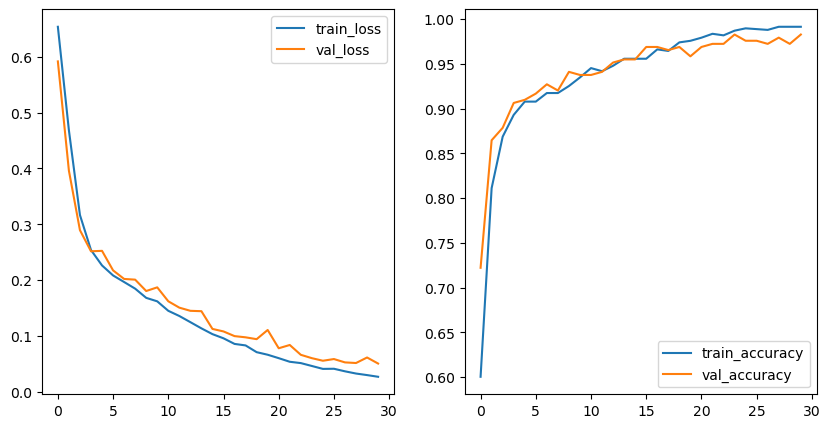

In [16]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


## YOUR CODE HERE
results = model.fit(X_pure_train, y_pure_train, epochs=30, batch_size=10, verbose=1, 
                   validation_data=(X_val, y_val))


train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
results = model.fit(X_pure_train, y_pure_train,
                   validation_data=(X_val, y_val),
                   epochs=30, batch_size=10)
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')
sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [17]:
results.history['val_accuracy'][-1]

0.9826388955116272

## Connecting with `sklearn`

The `keras.wrappers` submodule means that we can turn `keras` models into estimators that `sklearn` tools will recognize.

In [18]:
# This will throw an error.

cross_val_score(model, X_pure_train, y_pure_train)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <keras.engine.sequential.Sequential object at 0x2bbd033a0> does not.

In [19]:
def build_model():
    model = Sequential()
    model.add(Dense(12, activation='relu', input_dim=64))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [20]:
keras_model = scikit_learn.KerasClassifier(build_model,
                                          epochs=50,
                                          batch_size=32,
                                          verbose=1)

/var/folders/6m/p7gl74ts2mq9zbry092x3wsh0000gn/T/ipykernel_39270/2453450268.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_model = scikit_learn.KerasClassifier(build_model,


In [21]:
type(keras_model)

keras.wrappers.scikit_learn.KerasClassifier

In [23]:
# Can now cross_val
cross_val_score(keras_model, X_pure_train, y_pure_train, cv=3)

Epoch 1/50
 6/24 [======>.......................] - ETA: 0s - loss: 0.7454 - accuracy: 0.4688

2022-12-01 12:34:46.718377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 1s 12ms/step - loss: 0.7083 - accuracy: 0.5248
Epoch 2/50
24/24 [==============================] - 0s 8ms/step - loss: 0.6353 - accuracy: 0.6606
Epoch 3/50
24/24 [==============================] - 0s 8ms/step - loss: 0.5817 - accuracy: 0.7232
Epoch 4/50
24/24 [==============================] - 0s 8ms/step - loss: 0.5181 - accuracy: 0.7963
Epoch 5/50
24/24 [==============================] - 0s 7ms/step - loss: 0.4475 - accuracy: 0.8316
Epoch 6/50
24/24 [==============================] - 0s 7ms/step - loss: 0.3775 - accuracy: 0.8668
Epoch 7/50
24/24 [==============================] - 0s 7ms/step - loss: 0.3231 - accuracy: 0.8851
Epoch 8/50
24/24 [==============================] - 0s 7ms/step - loss: 0.2839 - accuracy: 0.8877
Epoch 9/50
24/24 [==============================] - 0s 7ms/step - loss: 0.2570 - accuracy: 0.8969
Epoch 10/50
24/24 [==============================] - 0s 7ms/step - loss: 0.2322 - accuracy: 0.9125
Epoch 11/50
24/24 [==========

2022-12-01 12:34:56.275459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 11ms/step - loss: 0.1003 - accuracy: 0.9608
Epoch 1/50
 1/24 [>.............................] - ETA: 7s - loss: 0.8036 - accuracy: 0.3125

2022-12-01 12:34:56.672850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 1s 13ms/step - loss: 0.7234 - accuracy: 0.4791
Epoch 2/50
24/24 [==============================] - 0s 7ms/step - loss: 0.6479 - accuracy: 0.6240
Epoch 3/50
24/24 [==============================] - 0s 7ms/step - loss: 0.6010 - accuracy: 0.7050
Epoch 4/50
24/24 [==============================] - 0s 7ms/step - loss: 0.5512 - accuracy: 0.7428
Epoch 5/50
24/24 [==============================] - 0s 7ms/step - loss: 0.4959 - accuracy: 0.8081
Epoch 6/50
24/24 [==============================] - 0s 7ms/step - loss: 0.4357 - accuracy: 0.8264
Epoch 7/50
24/24 [==============================] - 0s 7ms/step - loss: 0.3789 - accuracy: 0.8525
Epoch 8/50
24/24 [==============================] - 0s 7ms/step - loss: 0.3352 - accuracy: 0.8695
Epoch 9/50
24/24 [==============================] - 0s 7ms/step - loss: 0.3047 - accuracy: 0.8681
Epoch 10/50
24/24 [==============================] - 0s 7ms/step - loss: 0.2831 - accuracy: 0.8773
Epoch 11/50
24/24 [==========

2022-12-01 12:35:06.133566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/50
 1/24 [>.............................] - ETA: 7s - loss: 0.7548 - accuracy: 0.4375

2022-12-01 12:35:06.513558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 1s 14ms/step - loss: 0.7176 - accuracy: 0.4883
Epoch 2/50
24/24 [==============================] - 0s 9ms/step - loss: 0.6449 - accuracy: 0.6501
Epoch 3/50
24/24 [==============================] - 0s 8ms/step - loss: 0.5901 - accuracy: 0.7063
Epoch 4/50
24/24 [==============================] - 0s 8ms/step - loss: 0.5251 - accuracy: 0.7820
Epoch 5/50
24/24 [==============================] - 0s 8ms/step - loss: 0.4521 - accuracy: 0.8329
Epoch 6/50
24/24 [==============================] - 0s 8ms/step - loss: 0.3819 - accuracy: 0.8603
Epoch 7/50
24/24 [==============================] - 0s 8ms/step - loss: 0.3274 - accuracy: 0.8799
Epoch 8/50
24/24 [==============================] - 0s 8ms/step - loss: 0.2930 - accuracy: 0.8877
Epoch 9/50
24/24 [==============================] - 0s 8ms/step - loss: 0.2618 - accuracy: 0.8956
Epoch 10/50
24/24 [==============================] - 0s 8ms/step - loss: 0.2447 - accuracy: 0.8969
Epoch 11/50
24/24 [==========

2022-12-01 12:35:16.449908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 11ms/step - loss: 0.0880 - accuracy: 0.9661


array([0.96083552, 0.95561361, 0.96605748])

## Regularization

Does regularization make sense in the context of neural networks? <br/>

Yes! We still have all of the salient ingredients: a loss function, overfitting vs. underfitting, and coefficients (weights) that could get too large.

But there are now a few different flavors besides L1 and L2 regularization. (Note that L1 regularization is not common in the context of  neural networks.)

We'll add a few more layers to give regularization a better chance of making a difference!

In [ ]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))

# We can add L2 (or L1) regularization right into
# the layer with the kernel_regularizer parameter.

model.add(Dense(20, activation='relu', kernel_regularizer=))

# Note that there is also a bias_regularizer,
# but this tends to have less effect.

model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

Adding L2 to multiple layers:

2022-12-01 12:40:52.122236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-01 12:40:53.458412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


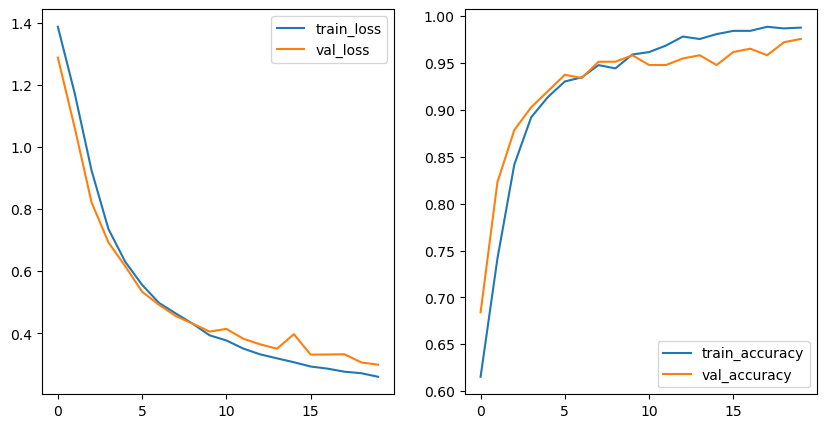

In [24]:
model = Sequential()
model.add(Dense(30, activation='relu',
                input_dim=64))
model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l2=0.01)))

model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(8, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(4, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Dropout

We can also specify a dropout layer in keras, which randomly shuts off different nodes during training. This can help to prevent overfitting.

![drop_out](images/drop_out.png)

### Exercise

To add dropout to a `keras` network, simply add it as though it were a layer. It will apply to the immediately preceding layer.

Add Dropout to one or more layers below.

In [ ]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
None
model.add(Dense(12, activation='relu'))
None
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [ ]:
results.history['val_accuracy'][-1]

### Early Stopping

We can also tell our neural network to stop once it stops realizing any gain.

Here we tell it to stop once the a very small positive change in the validation loss occurs:

2022-12-01 12:51:15.819713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-01 12:51:16.686558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 2: early stopping


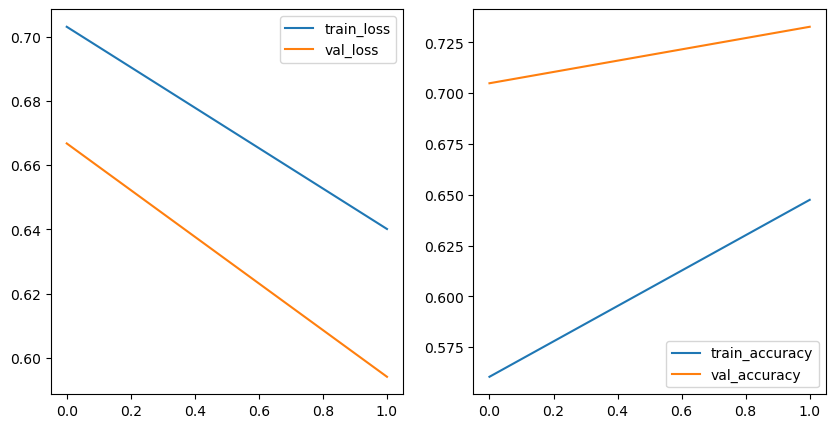

In [25]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1, patience=5,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Exercise

That probably stopped too early. We can specify the number of epochs in which it doesn't see decrease in the loss with the `patience` parameter. Modify the code below to include an Early Stop with a patience of 5 epochs.

2022-12-01 12:55:44.154914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-01 12:55:44.990703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 30: early stopping


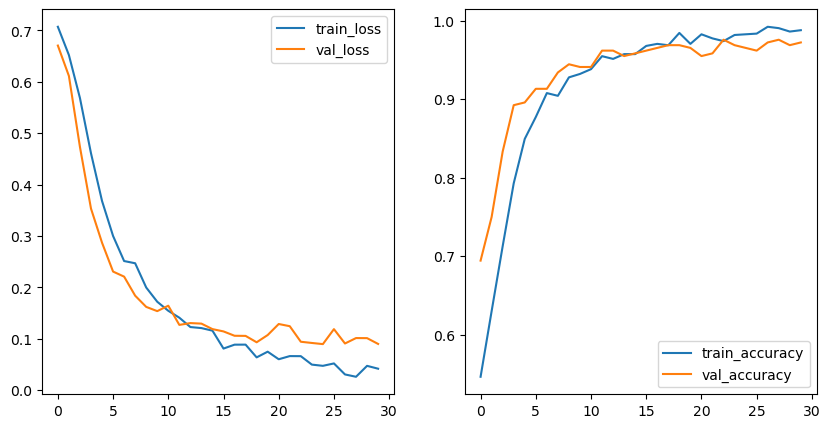

In [26]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1, patience=5,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object



# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [27]:
results.history['val_accuracy'][-1]

0.9722222089767456

## Multiclass Classification and Softmax

Now let's return to the problem of predicting digits 0 through 9.

In [40]:
digits = load_digits()
X = digits.data
y = digits.target

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)
X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train,
                     random_state=42, test_size=0.2)
X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For a multiclass output, our neural net expects our target to be in a certain form.

In [42]:
ohe = OneHotEncoder(sparse=False)
y_pure_train = ohe.fit_transform(y_pure_train.reshape(-1,1))
y_val = ohe.transform(y_val.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

In [31]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [44]:
# Model from above, but now with ten output neurons:

model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
# Final layer will look different need a node for each class
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                   epochs=50, batch_size=10,
                   validation_data=(X_val, y_val))

Epoch 1/50


2022-12-01 13:10:03.132879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


115/115 [==============================] - ETA: 0s - loss: 2.1281 - accuracy: 0.2176

2022-12-01 13:10:05.206820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


115/115 [==============================] - 3s 15ms/step - loss: 2.1281 - accuracy: 0.2176 - val_loss: 2.0250 - val_accuracy: 0.2917
Epoch 2/50
115/115 [==============================] - 1s 11ms/step - loss: 1.8475 - accuracy: 0.4091 - val_loss: 1.7590 - val_accuracy: 0.3993
Epoch 3/50
115/115 [==============================] - 1s 12ms/step - loss: 1.5641 - accuracy: 0.5178 - val_loss: 1.4977 - val_accuracy: 0.5069
Epoch 4/50
115/115 [==============================] - 1s 12ms/step - loss: 1.2753 - accuracy: 0.6284 - val_loss: 1.1887 - val_accuracy: 0.6806
Epoch 5/50
115/115 [==============================] - 1s 12ms/step - loss: 0.9725 - accuracy: 0.7633 - val_loss: 0.8829 - val_accuracy: 0.7882
Epoch 6/50
115/115 [==============================] - 1s 12ms/step - loss: 0.7436 - accuracy: 0.8251 - val_loss: 0.7096 - val_accuracy: 0.8333
Epoch 7/50
115/115 [==============================] - 1s 13ms/step - loss: 0.6075 - accuracy: 0.8547 - val_loss: 0.6013 - val_accuracy: 0.8472
Epoch 8/50

$$\large \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$

The sofmax function outputs a number between 0 and 1 for each of our classes.  All of the probabilities of the classes sum up to 1.

The number of nodes in our output layer equals the number of categories in our dataset.

We also need a new loss function: **categorical crossentropy**, which calculates a separate loss for each label and then sums the results.

In [45]:
history = results.history
training_loss = history['loss']
val_loss = history['val_loss']
training_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

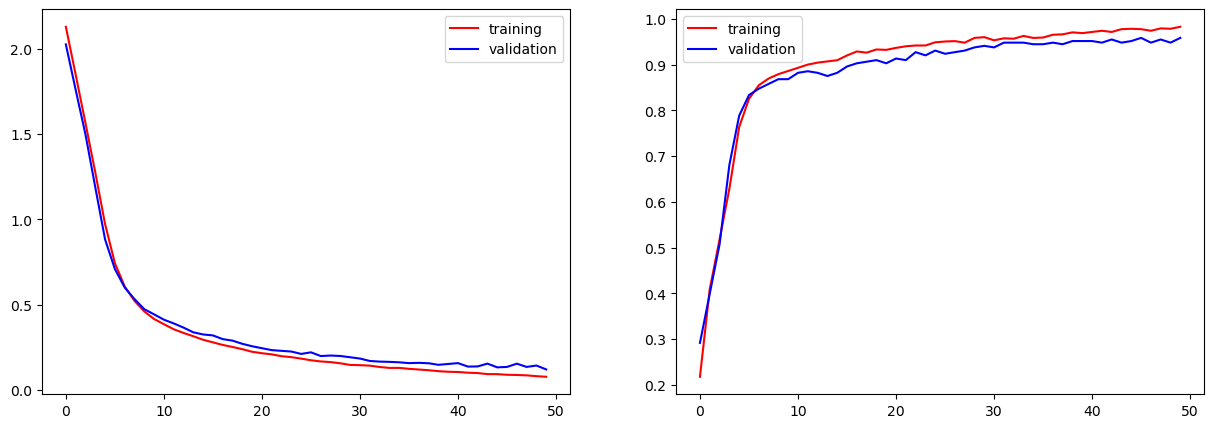

In [46]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x=list(range(len(training_loss))),
             y=training_loss, color='r', label='training', ax=ax1)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_loss, color='b', label='validation', ax=ax1)
sns.lineplot(x=list(range(len(training_loss))),
             y=training_accuracy, color='r', label='training',ax=ax2)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_accuracy, color='b', label='validation',ax=ax2)
ax1.legend();

In [47]:
model.predict(X_test)

12/12 [==============================] - 0s 3ms/step


2022-12-01 13:11:20.087315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[7.6677145e-07, 6.3158012e-08, 1.3185118e-13, ..., 1.1166655e-14,
        4.4081244e-06, 4.8694847e-06],
       [6.8659947e-04, 1.5147479e-06, 2.8450390e-11, ..., 8.7406766e-04,
        1.1822057e-04, 7.3475158e-01],
       [1.8218281e-12, 2.8047251e-09, 8.5125954e-05, ..., 1.0851574e-09,
        2.2555800e-04, 1.9464077e-04],
       ...,
       [5.1586687e-07, 2.9892194e-01, 2.1846720e-06, ..., 9.0933099e-02,
        5.6939876e-01, 1.7339593e-02],
       [1.8832062e-10, 2.7894495e-07, 1.7549682e-03, ..., 3.5600980e-09,
        1.9274620e-02, 1.5627911e-02],
       [2.4240857e-05, 1.5817344e-08, 1.9513115e-12, ..., 8.3896792e-09,
        7.4551526e-06, 3.9210888e-03]], dtype=float32)

In [48]:
model.predict(X_test)[0]

12/12 [==============================] - 0s 2ms/step


array([7.6677145e-07, 6.3158012e-08, 1.3185118e-13, 6.3493080e-13,
       1.8114857e-06, 4.4290144e-07, 9.9998760e-01, 1.1166655e-14,
       4.4081244e-06, 4.8694847e-06], dtype=float32)

In [ ]:
y_hat_test = np.argmax(model.predict(X_test), axis=-1)

In [ ]:
y_test_restore = ohe.inverse_transform(y_test)
confusion_matrix(y_test_restore, y_hat_test)

Wow, look at that performance!  

That is great, but remember, we were dealing with simple black and white images.  With color, our basic neural net will have less success.

